<a href="https://colab.research.google.com/github/ayyucedemirbas/t-SNE_visualization_patch_embeddings/blob/main/PCA_and_t_SNE_vis_patch_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.layers import LayerNormalization, Dense, Dropout, Layer
from tensorflow.keras import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, Flatten, Reshape

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
class PatchEmbedding(Layer):
    def __init__(self, patch_size, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patch_size = self.patch_size
        patches = tf.image.extract_patches(images=images,
                                           sizes=[1, patch_size, patch_size, 1],
                                           strides=[1, patch_size, patch_size, 1],
                                           rates=[1, 1, 1, 1],
                                           padding="VALID")
        patches = tf.reshape(patches, [batch_size, -1, patch_size * patch_size * 3])  # Flatten patches
        return patches


class VisionTransformer(Model):
    def __init__(self, num_classes, patch_size=4, embed_dim=128, num_heads=4, num_layers=4):
        super(VisionTransformer, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_layers = num_layers

        self.patch_embedding = PatchEmbedding(patch_size, embed_dim)
        self.encoder = [tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim) for _ in range(num_layers)]
        self.norm1 = LayerNormalization()
        self.norm2 = LayerNormalization()
        self.fc = Dense(num_classes)

    def call(self, inputs):

        x = self.patch_embedding(inputs)


        for layer in self.encoder:
            x = self.norm1(x)
            attention_output = layer(x, x)
            x = x + attention_output


        x = self.norm2(x)
        x = tf.reduce_mean(x, axis=1)
        x = self.fc(x)
        return x


In [ ]:
model = VisionTransformer(num_classes=10)


model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
# Train the Vision Transformer model on CIFAR-10
model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.2992 - loss: 1.9060 - val_accuracy: 0.4202 - val_loss: 1.5939
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.4390 - loss: 1.5391 - val_accuracy: 0.4430 - val_loss: 1.5181
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.4712 - loss: 1.4551 - val_accuracy: 0.4720 - val_loss: 1.4711
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.4889 - loss: 1.4022 - val_accuracy: 0.4759 - val_loss: 1.4394
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.5079 - loss: 1.3635 - val_accuracy: 0.4673 - val_loss: 1.4838


In [ ]:
def get_patch_embeddings(model, images):
    patch_embeddings = model.patch_embedding(images)
    return patch_embeddings.numpy()


batch_size = 64
images = x_test[:batch_size]


patch_embeddings = get_patch_embeddings(model, images)


patch_embeddings_flat = patch_embeddings.reshape(-1, patch_embeddings.shape[-1])  # Flatten patches


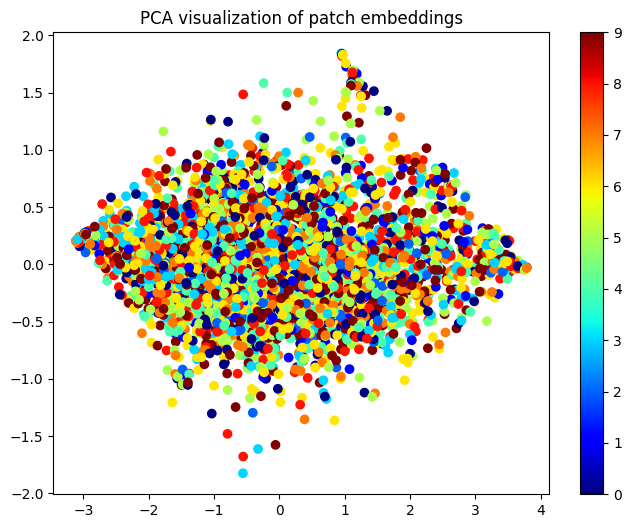

In [ ]:
# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(patch_embeddings_flat)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=np.tile(y_test[:batch_size], (patch_embeddings.shape[1], 1)).flatten(), cmap='jet')
plt.colorbar()
plt.title("PCA visualization of patch embeddings")
plt.show()


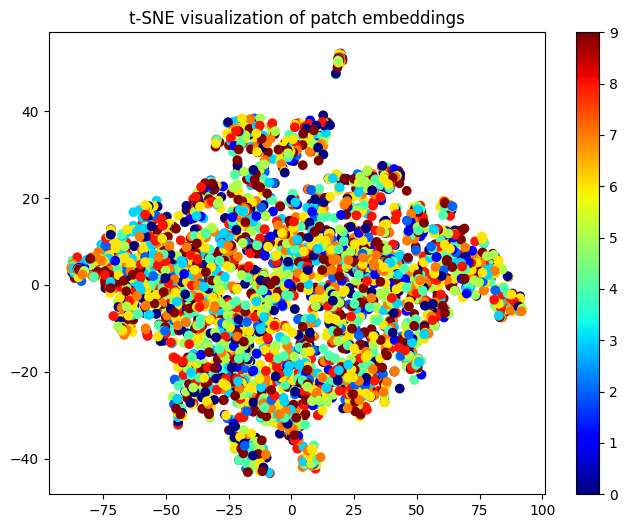

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(patch_embeddings_flat)


plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=np.tile(y_test[:batch_size], (patch_embeddings.shape[1], 1)).flatten(), cmap='jet')
plt.colorbar()
plt.title("t-SNE visualization of patch embeddings")
plt.show()
